In [18]:
import numpy as np
import json
import os
import sys
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])

# set matplotlib font size
plt.rcParams.update({
    "font.size": 12,         # Default font size for all text
    "axes.labelsize": 9,    # X and Y label font size
    "xtick.labelsize": 9,   # X-axis tick label font size
    "ytick.labelsize": 9,   # Y-axis tick label font size
    "legend.fontsize": 9,   # Legend font size
})

# Import plotting utility functions
sys.path.append('../')
from plot_util import (init_metrics, update_metrics, init_variables, update_variables,
                       plot_field, plot_field_residual, plot_field_columns, make_formatter, subsample_steps,
                        animate_frame, moving_average, moving_min)


In [35]:
# Select run to plot

results_folder = r"results"

measurments_type = ["displacement","strain","DIC"][1]
iteration = int(1e8)
time = 2
n_measurments = 2400 if measurments_type == "DIC" else 16 # 2400 for DIC simulated data
noise = 1e-6
smoothing = None # None, "min", "average"
window_size = 10

run = f"{measurments_type}_x{n_measurments}_{noise}noise_{time if time else iteration}{'min' if time else 'iter'}"


def get_folder_list(run, results_folder="./results/"):
    folder_list = []
    for folder_name in os.listdir(results_folder):
        if folder_name.startswith(run):
            folder_list.append(results_folder+folder_name)
    return folder_list


def read_data_file(filename):
    with open(filename, "r") as f:
        # Read the file and split each line
        steps = []
        values = []
        for line in f.readlines():
            step, value = line.strip().split(' ',1)
            steps.append(eval(step))
            values.append(eval(value))
    return steps, values


def load_runs(folder_list, window_size=10, smoothing=None):
    loss_history = []
    variables_history = []
    for folder in folder_list:
        loss_hist = np.loadtxt(folder + "/loss_history.dat")
        if smoothing == "min":
            loss_hist = moving_min(loss_hist, window_size)
        elif smoothing == "average":
            loss_hist = moving_average(loss_hist, window_size)
        loss_history.append(loss_hist)
        variables_history.append(read_data_file(folder + "/variables_history.dat"))

    steps_min = min(loss_hist.shape[0] for loss_hist in loss_history)
    loss_history = np.array([loss_hist[:steps_min] for loss_hist in loss_history])
    E_history = np.array([np.array(variables_hist[1])[:steps_min,0] for variables_hist in variables_history])
    nu_history = np.array([np.array(variables_hist[1])[:steps_min,1] for variables_hist in variables_history])

    return loss_history, E_history, nu_history

folder_list = get_folder_list(run)
print(f"{len(folder_list)} runs for {run}")

with open(folder_list[0] + "/config.json") as f:
    run_config = json.load(f)


loss_history, E_history, nu_history = load_runs(folder_list, window_size=window_size, smoothing=smoothing)

steps_loaded = loss_history[0,:, 0] 
residuals = loss_history[:,:, -1]
PDE_loss = np.mean(loss_history[:,:, 1:3], axis=2)
Mat_loss = np.mean(loss_history[:,:, 3:5], axis=2)
DIC_loss = np.mean(loss_history[:,:, 5:7], axis=2)

metrics = [residuals, PDE_loss, Mat_loss, DIC_loss]
metrics_names = ["Rel. l2 error", "PDE Loss", "Material Loss", "DIC Loss"]

# Table of final values
E_init = run_config["problem"]["E_init"]/1e3 # 1e3 N/m^2 = 1 GPa
nu_init = run_config["problem"]["nu_init"]

E_actual = run_config["problem"]["E_actual"]/1e3 # GPa
nu_actual = run_config["problem"]["nu_actual"]

E_finals = np.array([np.mean(E[-10:])/1e3 for E in E_history])
nu_finals = np.array([np.mean(nu[-10:]) for nu in nu_history])

print("-"*15*8)
print(f"{'Parameter':<15}{'Initial':<15}{'Final mean':<15}{'Final std':<15}{'Final min':<15}{'Final max':<15}{'Reference':<15}{'Max Rel. Error':<15}")
print("-"*15*8)
print(f"{'E':<15}{E_init:<15.4f}{np.mean(E_finals):<15.4f}{np.std(E_finals):<15.4f}{np.min(E_finals):<15.4f}{np.max(E_finals):<15.4f}{E_actual:<15.4f}{np.max(np.abs(E_finals - E_actual)/E_actual)*100:<15.4f}%")
print(f"{'nu':<15}{nu_init:<15.4f}{np.mean(nu_finals):<15.4f}{np.std(nu_finals):<15.4f}{np.min(nu_finals):<15.4f}{np.max(nu_finals):<15.4f}{nu_actual:<15.4f}{np.max(np.abs(nu_finals - nu_actual)/nu_actual)*100:<15.4f}%")

10 runs for strain_x16_1e-06noise_2min
------------------------------------------------------------------------------------------------------------------------
Parameter      Initial        Final mean     Final std      Final min      Final max      Reference      Max Rel. Error 
------------------------------------------------------------------------------------------------------------------------
E              100.0000       209.4616       0.1205         209.3467       209.7501       210.0000       0.3111         %
nu             0.2000         0.2999         0.0002         0.2997         0.3003         0.3000         0.1121         %


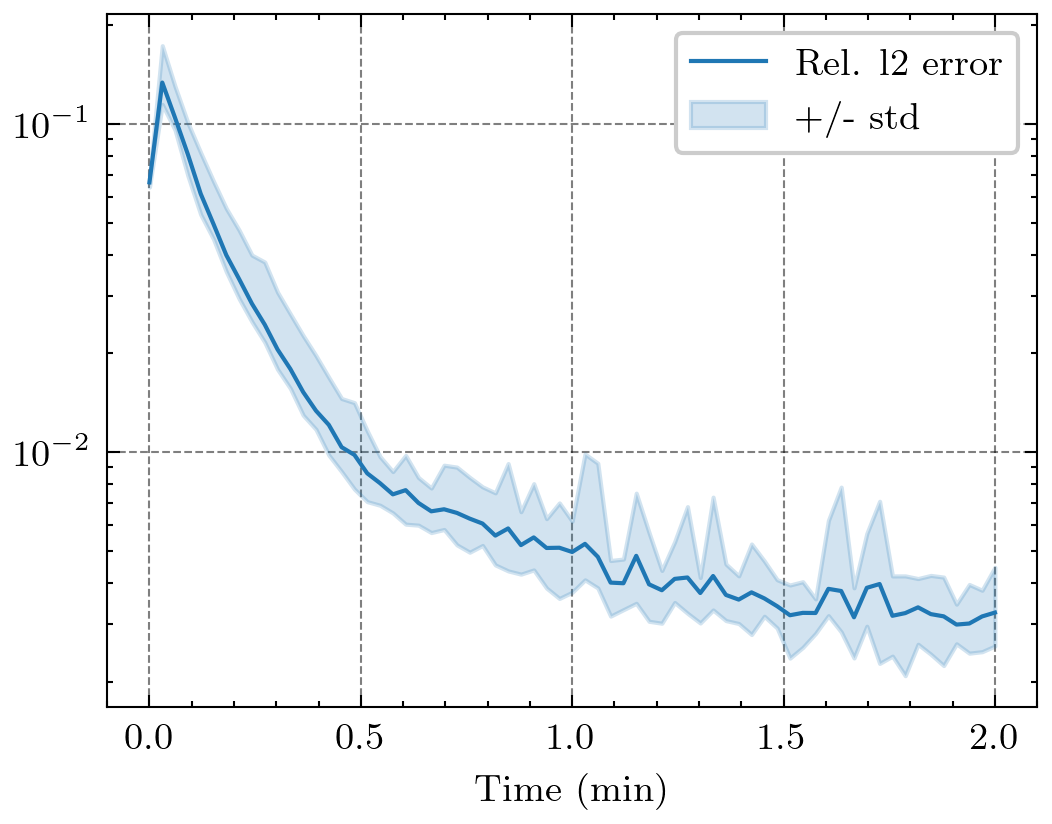

In [34]:
import matplotlib.pyplot as plt


step_type = ["iteration", "time"][1]
time_unit = ["s", "min"][1]
metrics_idx = [0,1,2,3][0:1]  # 0: residuals, 1: PDE loss, 2: Material loss, 3: DIC loss
t_elapsed = run_config["execution"]["elapsed"]
if step_type == "time":
    steps = np.array(steps_loaded) * time / steps_loaded[-1]
else:
    steps = steps_loaded

palette = plt.get_cmap('tab10').colors

def init_metrics(ax, metrics_idx=[0]):
    ax.set_yscale('log')
    lines = []
    scatters = []
    for idx in metrics_idx:
        ax.plot(steps, metrics[idx].mean(axis=0), alpha=1, color=palette[idx])
        lines.append(ax.plot([], [], zorder=3, color=palette[idx], label=metrics_names[idx])[0])
        ax.fill_between(steps, metrics[idx].min(axis=0), metrics[idx].max(axis=0), alpha=0.2, color=palette[idx], label="+/- std")
        scatters.append(ax.scatter([], [], c='k', zorder=4))
    ax.legend()
    if step_type == "time":
        ax.set_xlabel(f"Time ({time_unit})")
    else:
        ax.set_xlabel("Iterations")
    return lines, scatters

def update_metrics(iterations, lines, scatters, metrics_idx=[0]):
    for line, scatter in zip(lines, scatters):
        for idx in metrics_idx:
            line.set_data(steps, metrics[idx][:iterations].mean(axis=0))
            scatter.set_offsets(np.array([steps[iterations], metrics[idx][:iterations].mean(axis=0)]).T)
    return lines, scatters


fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=300)
lines, scatters = init_metrics(ax,  metrics_idx=metrics_idx)
# update_metrics(-1, lines, scatters, metrics_idx=metrics_idx)
plt.show()

# anim = animation.FuncAnimation(fig, update_losshistory, fargs=(line_pinn, line_spinn, scatter_pinn, scatter_spinn), frames=int(len(losshistory_pinn)/10), interval=100, repeat=False)
# HTML(anim.to_jshtml())

In [10]:
import seaborn as sns
sns.set_style("whitegrid")

plot_type = ['boxplot', 'violinplot'][1]

def plot_distribution(ax,df, parameter,metric,plot_type="violinplot",strip=True,label_info=True,save_fig=False,color="blue"):
    if plot_type == 'boxplot':
        sns.boxplot(x=parameter, y=metric, data=df, ax=ax)#, color="0.8")

    elif plot_type == 'violinplot':
        sns.violinplot(x=parameter, y=metric, data=df, ax=ax,inner="quartile", color=color)
  
    for patch in ax.collections:
        patch.set_alpha(0.7)  
        
    if strip:    
        sns.stripplot(x=parameter, y=metric, data=df,ax=ax, jitter=0.03, zorder=1, size=5, alpha=0.6, color="black")
    if label_info:
        # Calculate mean and number of points for each category
        mean_values = df.groupby(parameter)[metric].mean()
        std_values = df.groupby(parameter)[metric].std()
        count_values = df[parameter].value_counts()

        # Add labels for each category
        column_values = sorted(df[parameter].unique(),key=str.casefold if isinstance(df[parameter].iloc[0],str) else lambda x: x)
        
        for i, value in enumerate(column_values):
            mean = mean_values[value]
            std = std_values[value]
            count = count_values[value]
            label = f"Mean: {mean:.2e}\nStd: {std:.2e}\nCount: {count}"
            ax.text(i, ax.get_ylim()[1], label, ha='center', va='top',
                bbox=dict(boxstyle='square,pad=0.5', fc='1', ec='0.5'),
                transform=ax.transData)
                        
            
    if save_fig:
        plt.savefig(f"results/figures/{parameter}_influence.png",dpi=300)

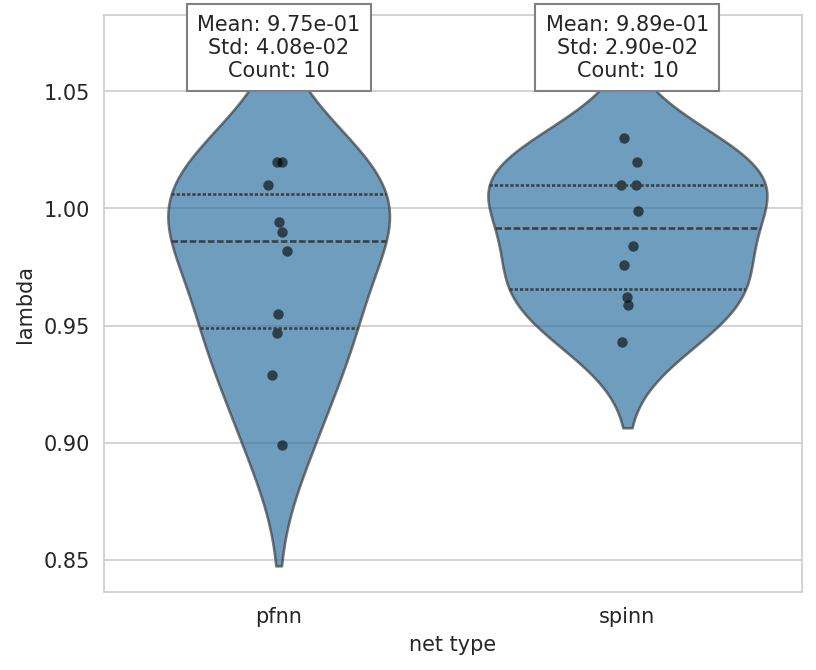

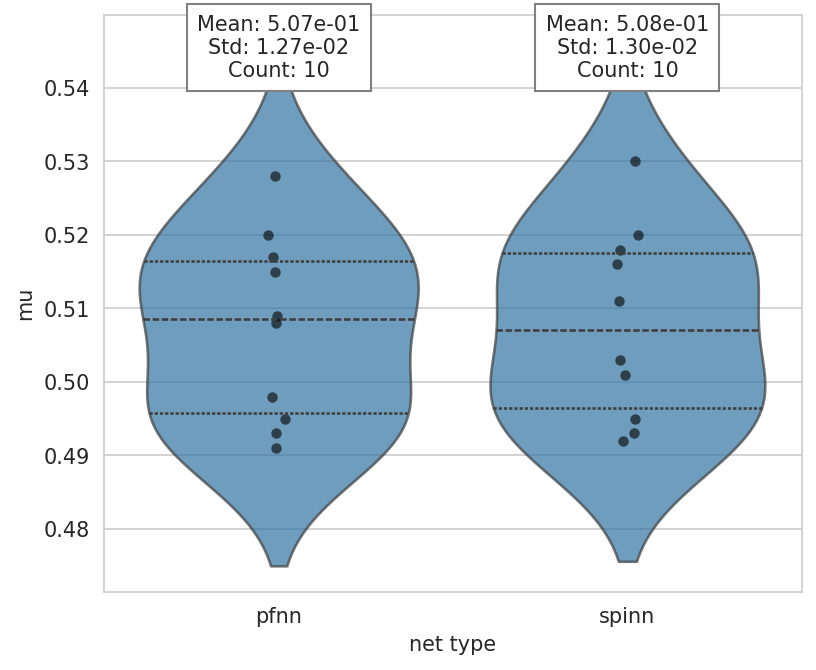

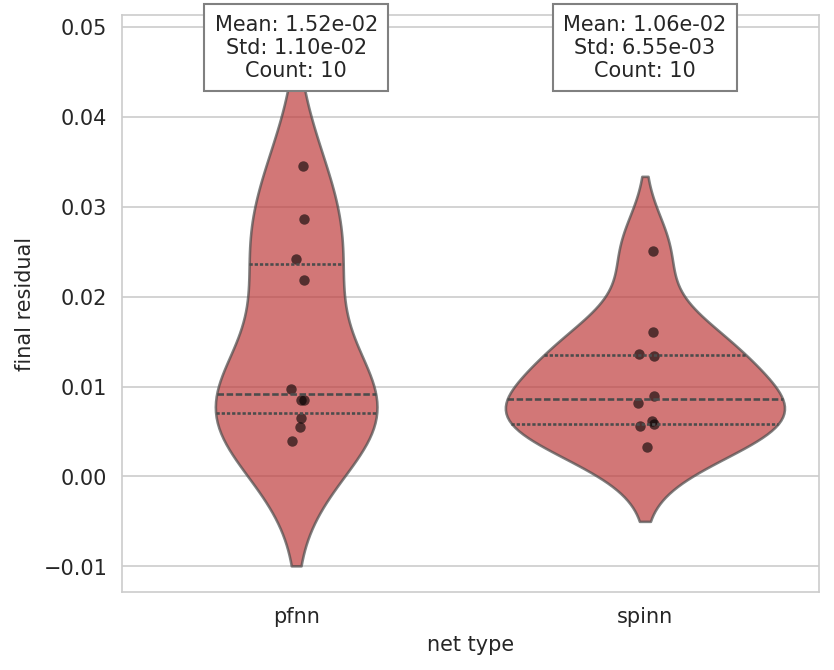

In [ ]:
import pandas as pd

final_res = [residuals[comp_id][:, -1] for comp_id in range(len(comparaison_types))]
final_lambda = [E_history[:, -1] for comp_id in range(len(comparaison_types))]
final_mu = [nu_history[:, -1] for comp_id in range(len(comparaison_types))]

df_final = []
comp_idx = [0,1] #0: PINN, 1: SPINN

for comp_id in comp_idx:
    for i in range(len(final_res[comp_id])):
        df_final.append({"final residual": final_res[comp_id][i], "lambda": final_lambda[comp_id][i], "mu": final_mu[comp_id][i], "net type": comparaison_types[comp_id]})

df_final = pd.DataFrame(df_final)


palette = sns.color_palette()
fig, ax = plt.subplots(1, 1, figsize=(3*len(comp_idx), 5), dpi=150)
plot_distribution(ax,df_final, "net type", "lambda", color=palette[0])

fig, ax = plt.subplots(1, 1, figsize=(3*len(comp_idx), 5), dpi=150)
plot_distribution(ax,df_final, "net type", "mu", color=palette[0])

fig, ax = plt.subplots(1, 1, figsize=(3*len(comp_idx), 5), dpi=150)
plot_distribution(ax,df_final, "net type", "final residual", color=palette[3])

# df_final.head()


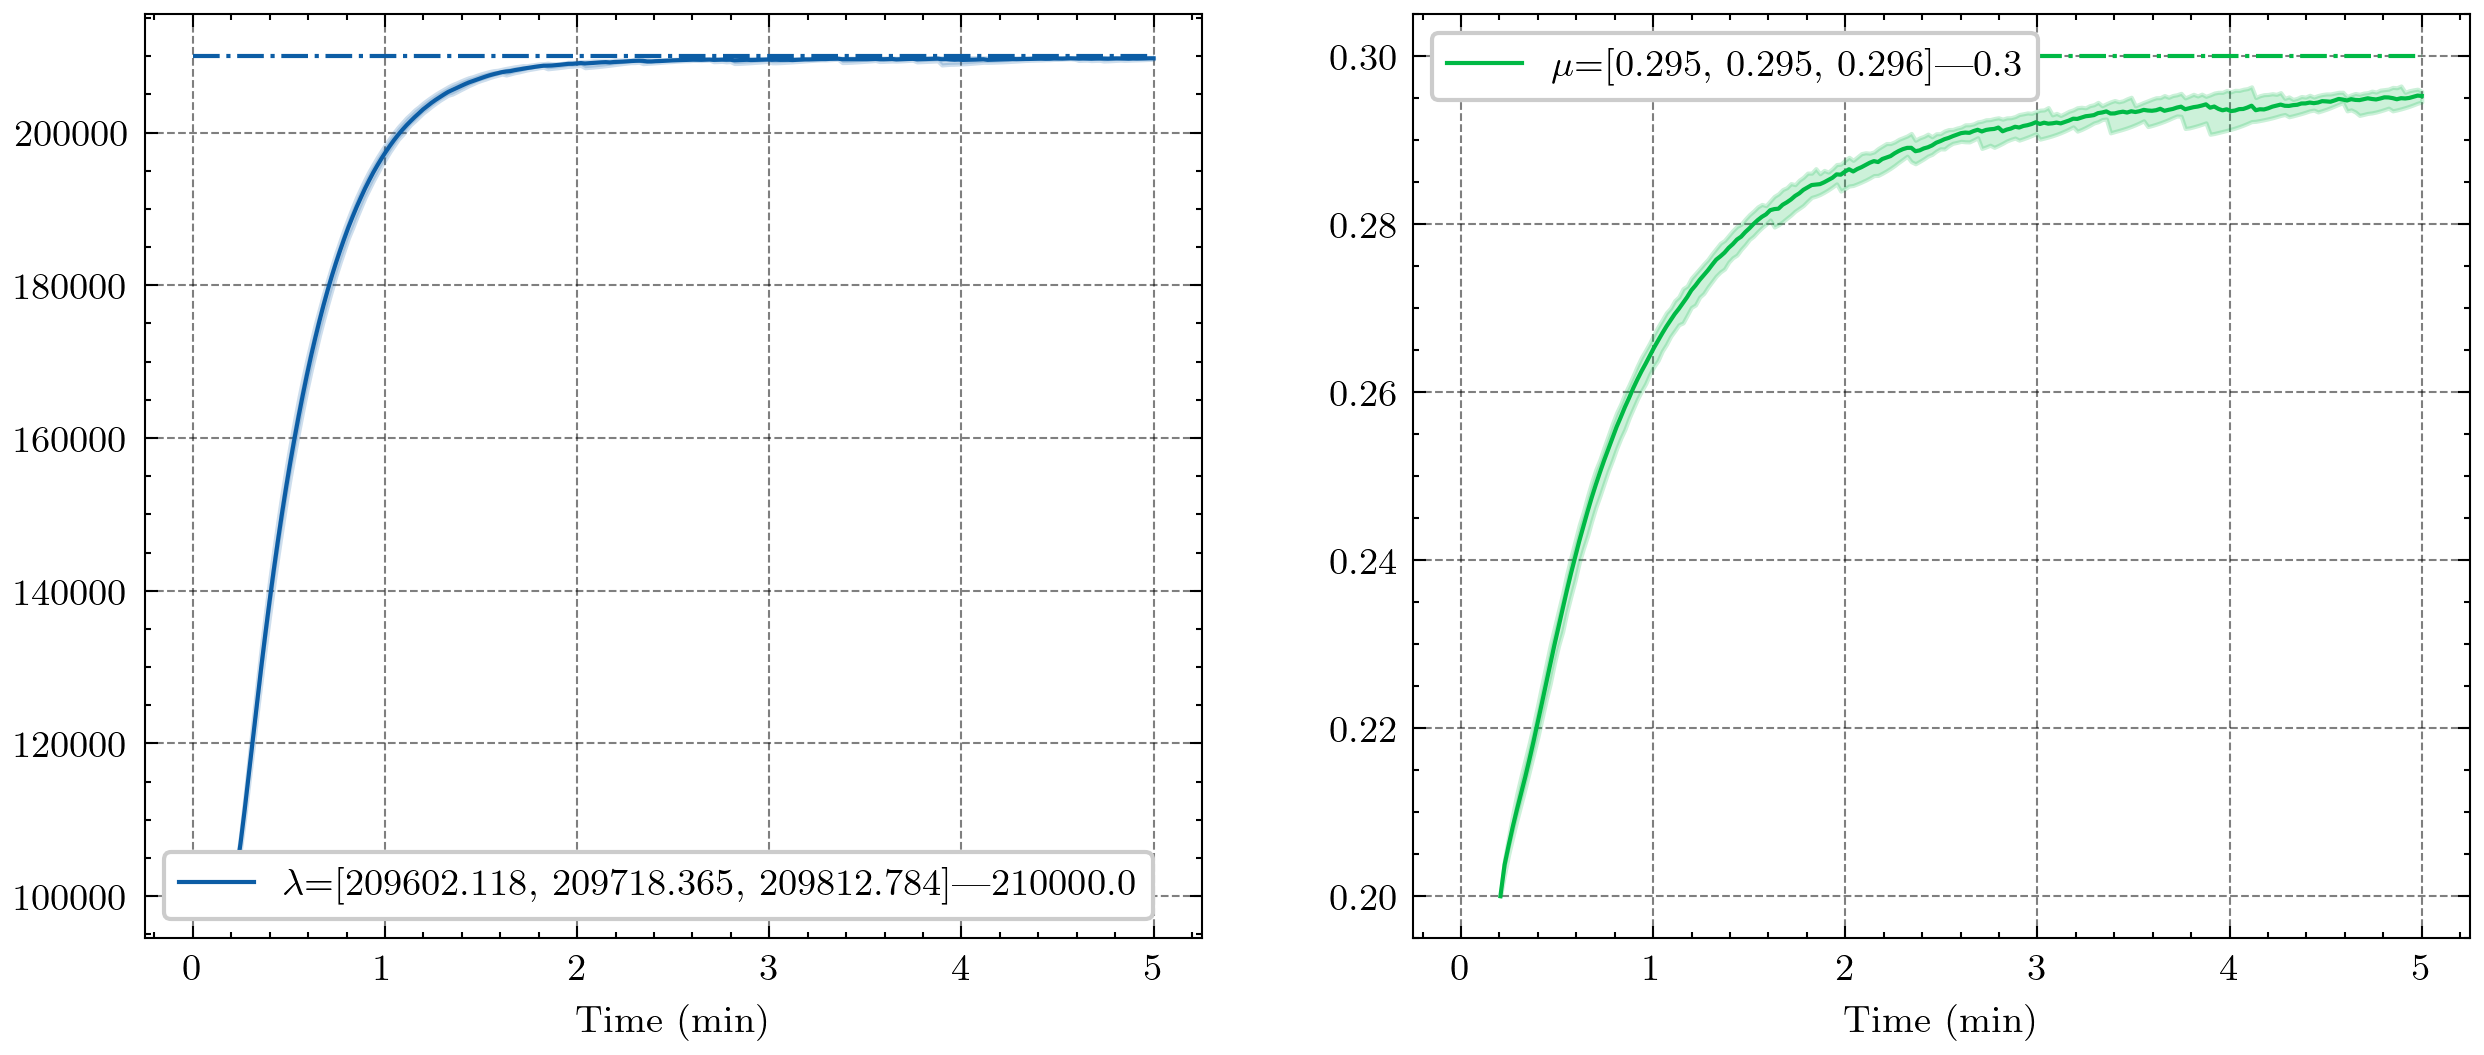

In [ ]:
lambda_actual = run_config["problem"]["E_actual"]
mu_actual = run_config["problem"]["nu_actual"]


def init_variables(ax):
    ax[0].hlines(y=lambda_actual, xmin=0, xmax=steps.max(), linestyles='-.', colors=palette[0])
    ax[1].hlines(y=mu_actual, xmin=0, xmax=steps.max(), linestyles='-.', colors=palette[1])
    ax[0].plot(steps, E_history.mean(axis=0), color=palette[0], alpha=1, label=r"$\lambda$"+f"=[{E_history.min(axis=0)[-1]:.3f}, {E_history.mean(axis=0)[-1]:.3f}, {E_history.max(axis=0)[-1]:.3f}]|{lambda_actual}")
    ax[1].plot(steps, nu_history.mean(axis=0), color=palette[1], alpha=1, label=r"$\mu$"+f"=[{nu_history.min(axis=0)[-1]:.3f}, {nu_history.mean(axis=0)[-1]:.3f}, {nu_history.max(axis=0)[-1]:.3f}]|{mu_actual}")
    ax[0].fill_between(steps, E_history.min(axis=0), E_history.max(axis=0), alpha=0.2, color=palette[0])
    ax[1].fill_between(steps, nu_history.min(axis=0), nu_history.max(axis=0), alpha=0.2, color=palette[1])

    ax[0].legend()
    ax[1].legend()

    if step_type == "time":
        for axi in ax:
            axi.set_xlabel(f"Time ({time_unit})") 
    else:
        for axi in ax:
            axi.set_xlabel("Iterations")
    
    return ax

def update_variables(iterations, line_lambda, line_mu, scatter_mu, scatter_lambda,ax):

    line_lambda.set_data(steps[:iterations], E_history.mean(axis=0)[:iterations])
    line_lambda.set_label(r"$\lambda$"+f"={E_history.mean(axis=0)[iterations]:.3f}|{lambda_actual}")
    scatter_lambda.set_offsets([steps[iterations], E_history.mean(axis=0)[iterations]])
    line_mu.set_data(steps[:iterations], nu_history.mean(axis=0)[:iterations])
    line_mu.set_label(r"$\mu$"+f"={nu_history.mean(axis=0)[iterations]:.3f}|{mu_actual}")
    scatter_mu.set_offsets([steps[iterations], nu_history.mean(axis=0)[iterations]])
    ax.legend()
    return line_lambda, line_mu, scatter_mu, scatter_lambda, ax

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax = init_variables(ax)
# update_variables(-1, line_lambda, line_mu, scatter_mu, scatter_lambda, ax)
plt.show()

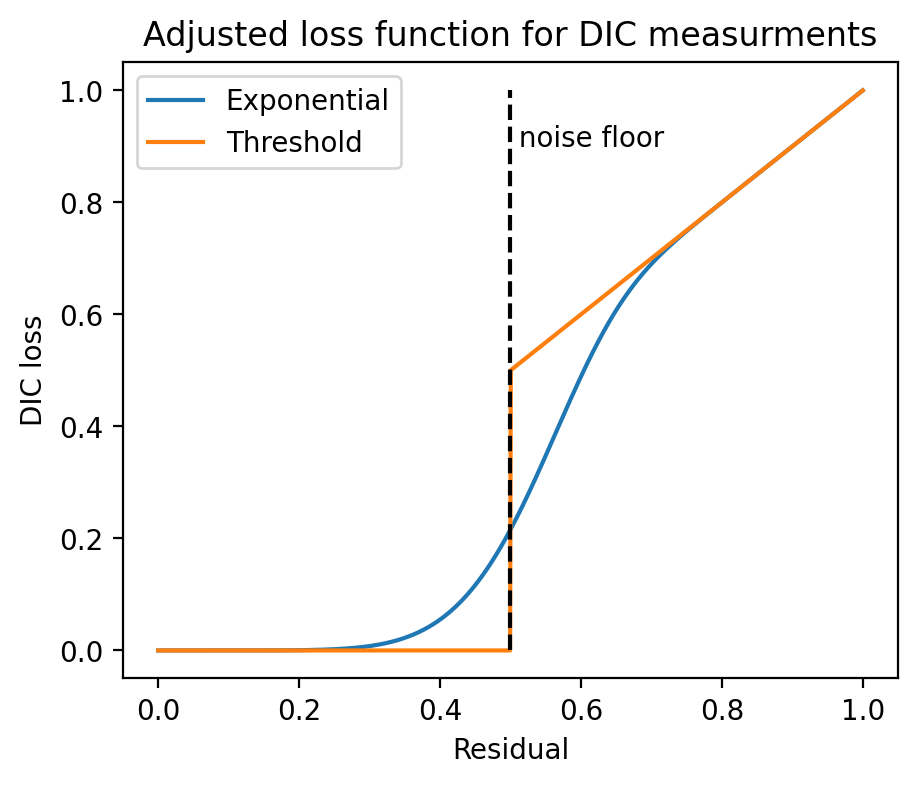

In [86]:
#exponential decay
max_range = 1
noise_floor = max_range/2
dist = np.linspace(0, max_range, 1000)

def exponential_loss(dist, noise_floor):
    return dist*(1-np.exp(-(dist/(1.1*noise_floor))**6))
def threshold_loss(dist, noise_floor):
    return np.where(np.abs(dist)<noise_floor, 0, dist)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)
plt.plot(dist, exponential_loss(dist, noise_floor), label="Exponential")
plt.plot(dist, threshold_loss(dist, noise_floor), label="Threshold")
# plt.plot(dist, dist, 'k--')
plt.vlines(noise_floor, 0, max_range, linestyles='--',colors='k')
plt.text(noise_floor, max_range*0.9, f" noise floor", color='k')
plt.title("Adjusted loss function for DIC measurments")
plt.xlabel("Residual")
plt.ylabel("DIC loss")
plt.legend()
